In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [11]:
sys.path.append("..")
from model.uplift_model import *
from model.roi_model import *

In [12]:
import matplotlib.pyplot as plt

def plot_loss(history, *losses):
    for loss in losses:
        plt.plot(history.history[loss], label=loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [13]:
import causalml
from causalml.metrics import *
import matplotlib.pyplot as plt


def get_causalml_auuc(Y, T, ite_pred, normalize=True):

    metric_df = pd.DataFrame([ite_pred.flatten(),
                               Y.flatten(),
                               T.flatten()]).T


    metric_df.columns=['model','y','w'] 
    uplift_rank_lift = get_cumlift(metric_df)

    normalize = True

    uplift_rank_gain = uplift_rank_lift.mul(uplift_rank_lift.index.values, axis=0)
    if normalize:
        uplift_rank_gain = uplift_rank_gain.div(np.abs(uplift_rank_gain.iloc[-1, :]), axis=1)
    uplift_rank_auuc_score = uplift_rank_gain.sum()/uplift_rank_gain.shape[0]
    
    print(uplift_rank_auuc_score)
    
    step = len(T) // 200 
    
    uplift_rank_gain.iloc[::step, :].plot()
    plt.show()
    
    return uplift_rank_auuc_score, uplift_rank_gain.iloc[::step, :]

In [19]:
count = 20

trainable_weights
p1_hidden_1/kernel:0
p1_hidden_1/bias:0
p1_hidden_2/kernel:0
p1_hidden_2/bias:0
p1/kernel:0
p1/bias:0
non_trainable_weights
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
p0_raw_features (InputLayer)    [(None, 76)]         0                                            
__________________________________________________________________________________________________
treated_input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 77)           0           p0_raw_features[0][0]            
                                                                 treated_input[0][0]              
_________________________________________________

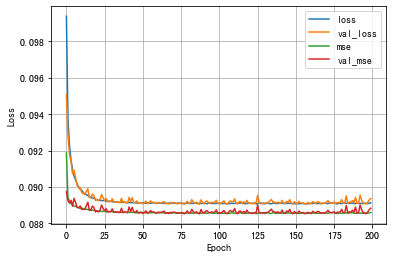

iteration =  2


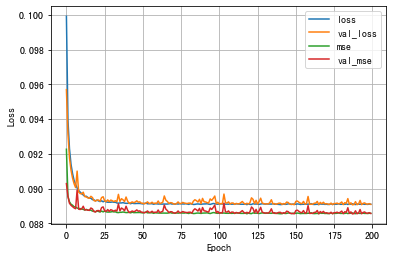

iteration =  3


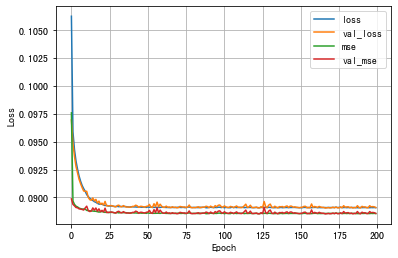

iteration =  4


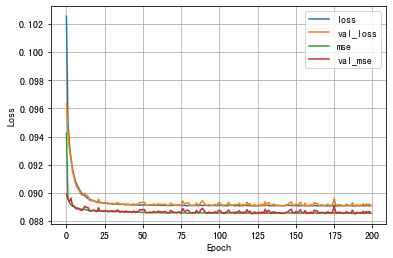

iteration =  5


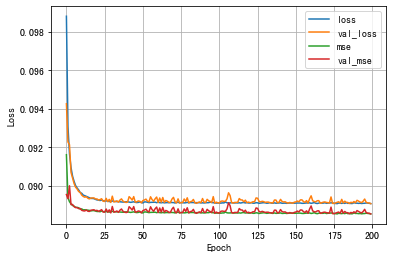

iteration =  6


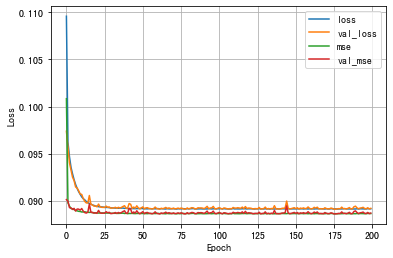

iteration =  7


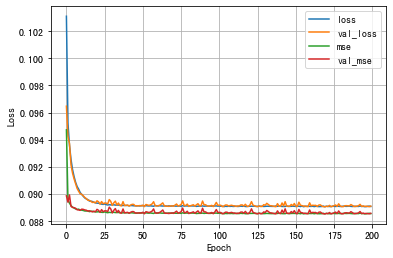

iteration =  8


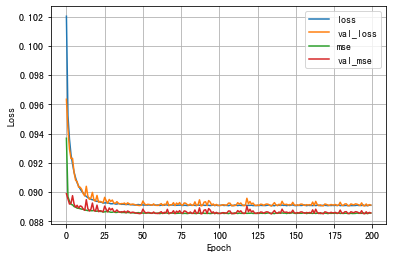

iteration =  9


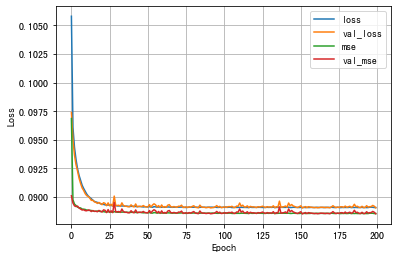

iteration =  10


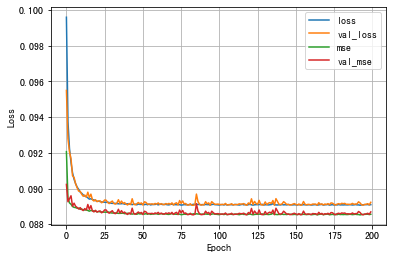

iteration =  11


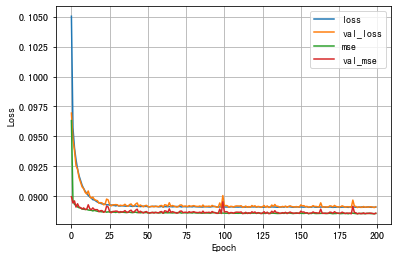

iteration =  12


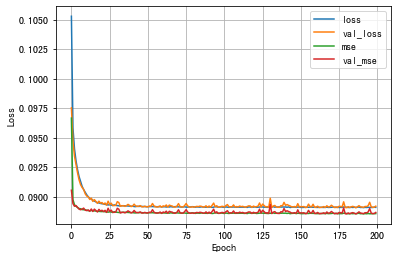

iteration =  13


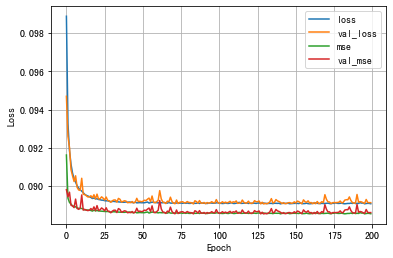

iteration =  14


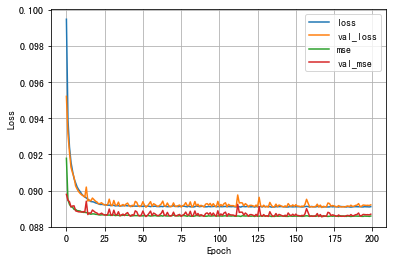

iteration =  15


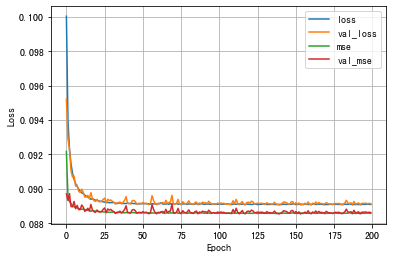

iteration =  16


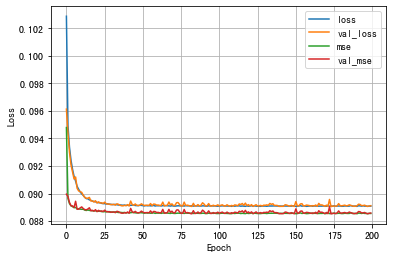

iteration =  17


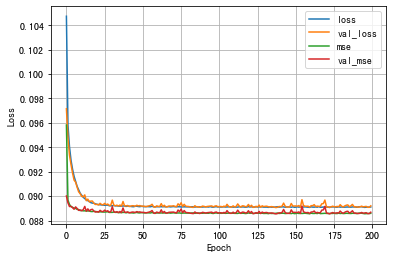

iteration =  18


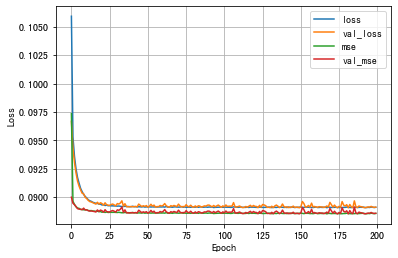

iteration =  19


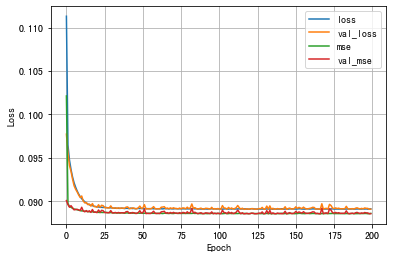

iteration =  20


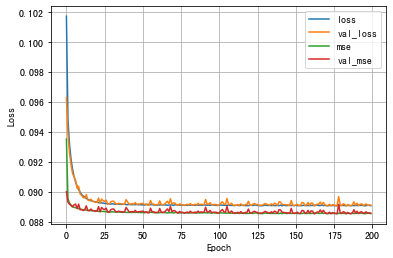

In [20]:
# S-Learner
# 1e-4
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.uplift_model import *

final_model = get_slearner_model()
final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#lambda y_true,y_pred: y_pred
print('trainable_weights')
for x in final_model.trainable_weights:
    print(x.name)
print('non_trainable_weights')
for x in final_model.non_trainable_weights:
    print(x.name)
final_model.summary()


for i in range(count):

    print("iteration = ", i + 1)
    
    final_model = get_slearner_model()
    final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    mcp_save = ModelCheckpoint('../model_file/uplift/marketing/final_model/slearner/slearner_marketing_model_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit([X, T], Yr, validation_split=0.2, epochs=200, batch_size=4096, shuffle=True, verbose=0, callbacks=[mcp_save])

        
    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    

In [28]:
count = 20

trainable_weights
p1_hidden_1/kernel:0
p1_hidden_1/bias:0
p1_hidden_2/kernel:0
p1_hidden_2/bias:0
p1/kernel:0
p1/bias:0
non_trainable_weights
Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
p0_raw_features (InputLayer) [(None, 76)]              0         
_________________________________________________________________
p1_hidden_1 (Dense)          (None, 64)                4928      
_________________________________________________________________
p1_hidden_2 (Dense)          (None, 32)                2080      
_________________________________________________________________
p1 (Dense)                   (None, 1)                 33        
Total params: 7,041
Trainable params: 7,041
Non-trainable params: 0
_________________________________________________________________
iteration =  1


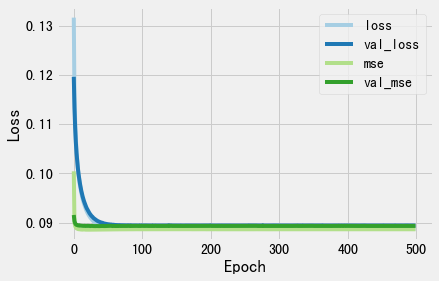



iteration =  2


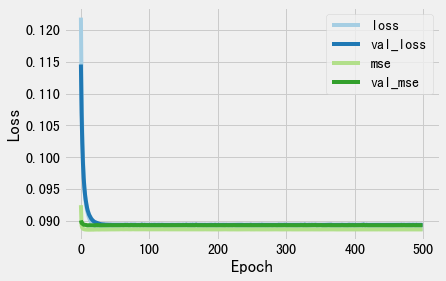



iteration =  3


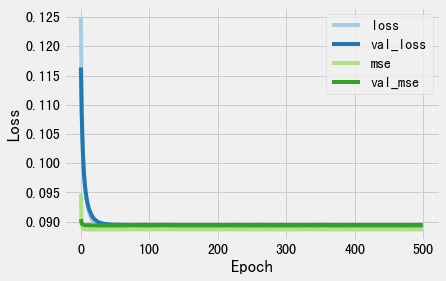



iteration =  4


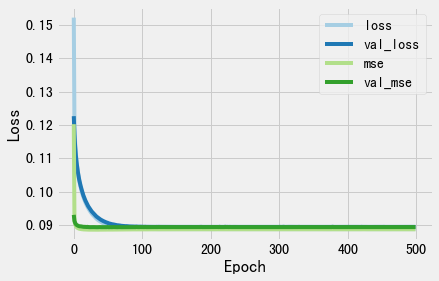



iteration =  5


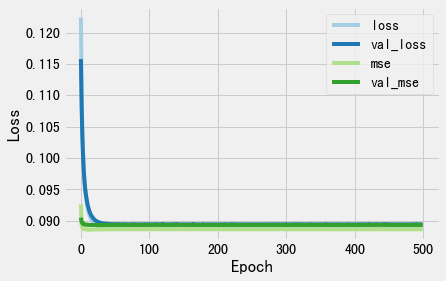



iteration =  6


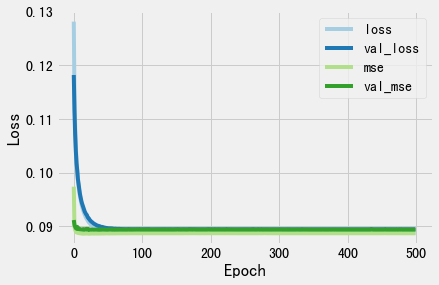



iteration =  7


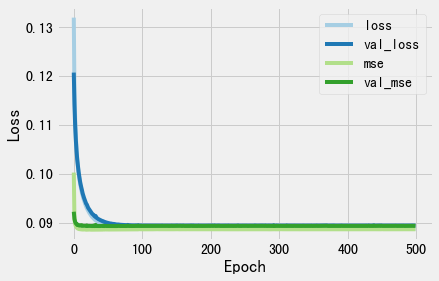



iteration =  8


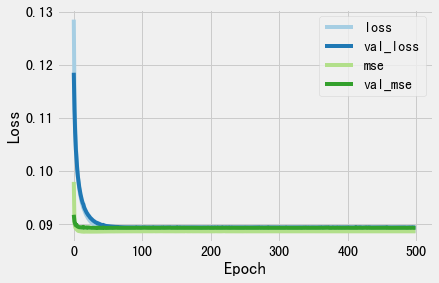



iteration =  9


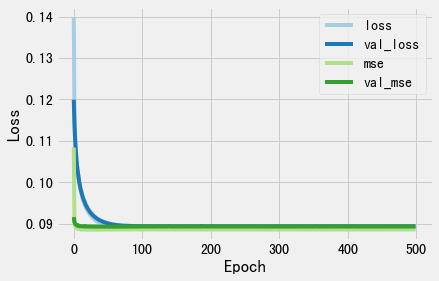



iteration =  10


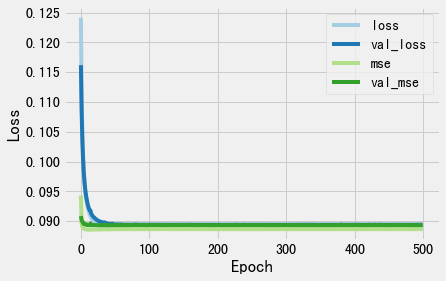



iteration =  11


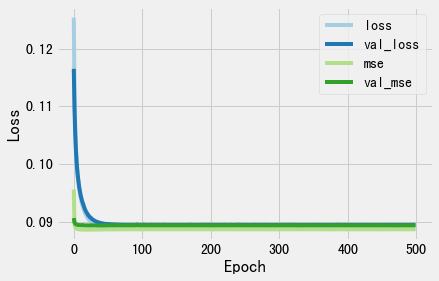



iteration =  12


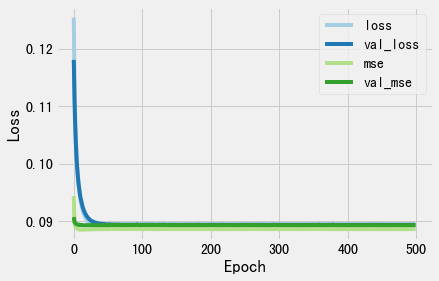



iteration =  13


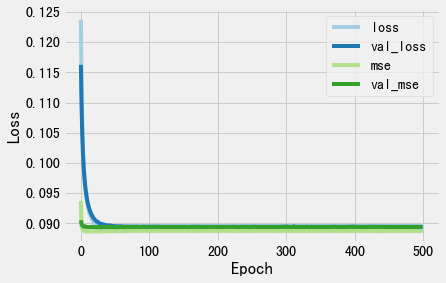



iteration =  14


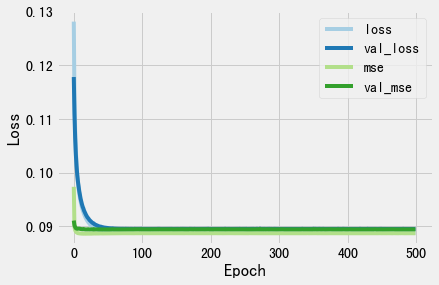



iteration =  15


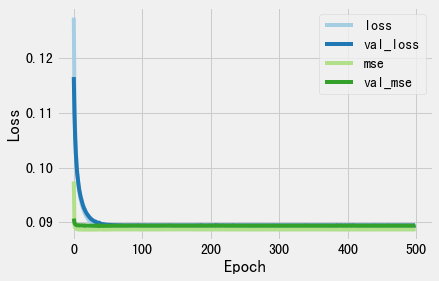



iteration =  16


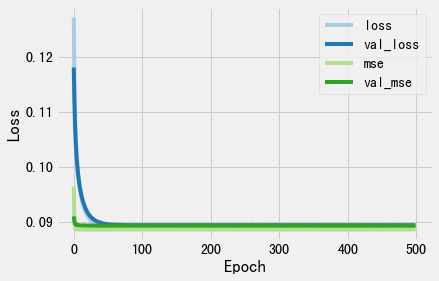



iteration =  17


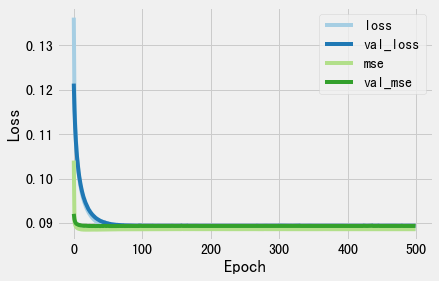



iteration =  18


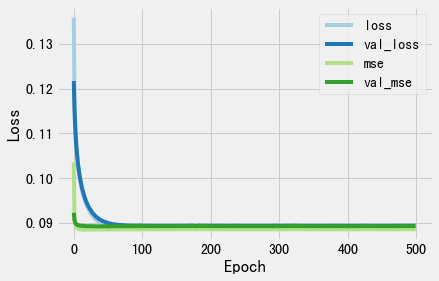



iteration =  19


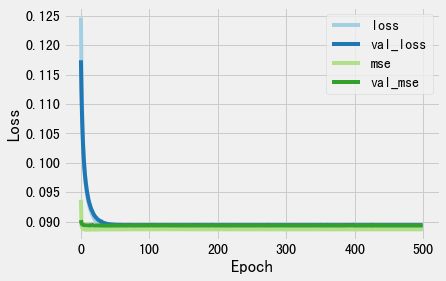



iteration =  20


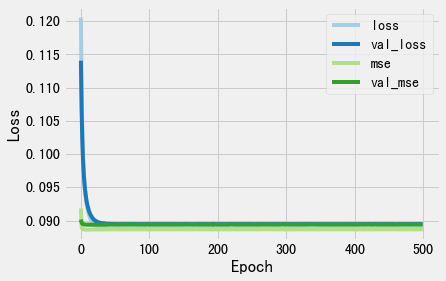

In [32]:
# X LEARNER MODEL
# tau_0 3e-4
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.uplift_model import *

final_model = get_xlearner_model()
final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#lambda y_true,y_pred: y_pred
print('trainable_weights')
for x in final_model.trainable_weights:
    print(x.name)
print('non_trainable_weights')
for x in final_model.non_trainable_weights:
    print(x.name)
final_model.summary()


for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_slearner_model()
    final_model.load_weights('../model_file/uplift/marketing/final_model/slearner/slearner_marketing_model_{}.h5'.format(i+1))
    T0 = np.zeros(shape=T.shape)
    T1 = np.ones(shape=T.shape)
    p0 = final_model.predict([X,  T0])
    p1 = final_model.predict([X,  T1])
    
    X_0 = X[(T.flatten() < 0.5), :]
    X_1 = X[(T.flatten() >= 0.5), :]

    X_0_p1_pre = p1[(T < 0.5)]
    X_1_p0_pre = p0[(T >= 0.5)]

    Yr_0 = Yr[(T < 0.5)]
    Yr_1 = Yr[(T >= 0.5)]

    tau_0_label = X_0_p1_pre - Yr_0
    tau_1_label = Yr_1 - X_1_p0_pre
    
    
    final_model = get_xlearner_model_tau0()
    final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    mcp_save = ModelCheckpoint('../model_file/uplift/marketing/final_model/xlearner/xlearner_marketing_model_tau_0_{}_3e-4.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit(X_0, tau_0_label, validation_split=0.2, epochs=500, batch_size=4096, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    
#     final_model = get_xlearner_model()
#     final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

#     mcp_save = ModelCheckpoint('../model_file/uplift/marketing/final_model/xlearner/xlearner_marketing_model_tau_1_{}.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
#     history = final_model.fit(X_1, tau_1_label, validation_split=0.2, epochs=500, batch_size=4096, shuffle=True, verbose=0, callbacks=[mcp_save])

#     plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    print("\n")
    


trainable_weights
p1_hidden_1/kernel:0
p1_hidden_1/bias:0
p1_hidden_2/kernel:0
p1_hidden_2/bias:0
p1/kernel:0
p1/bias:0
non_trainable_weights
Model: "model_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
p0_raw_features (InputLayer) [(None, 76)]              0         
_________________________________________________________________
p1_hidden_1 (Dense)          (None, 64)                4928      
_________________________________________________________________
p1_hidden_2 (Dense)          (None, 32)                2080      
_________________________________________________________________
p1 (Dense)                   (None, 1)                 33        
Total params: 7,041
Trainable params: 7,041
Non-trainable params: 0
_________________________________________________________________
iteration =  1


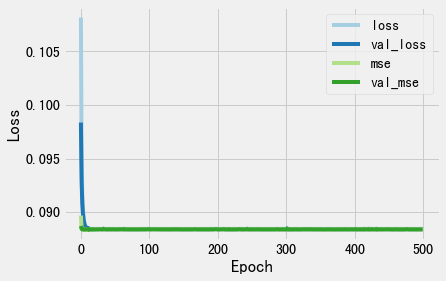



iteration =  2


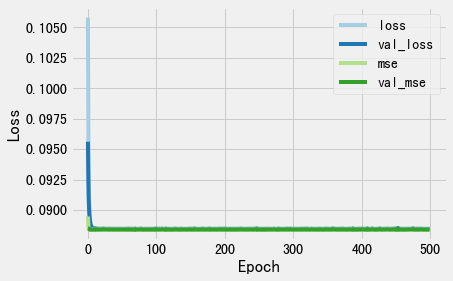



iteration =  3


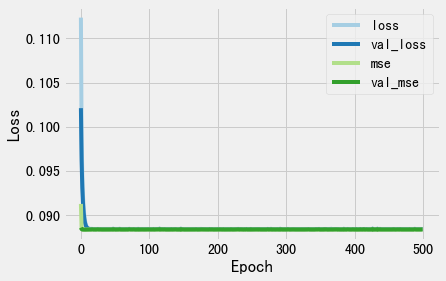



iteration =  4


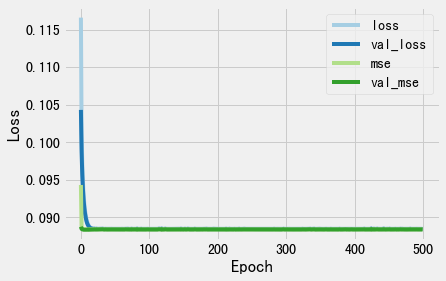



iteration =  5


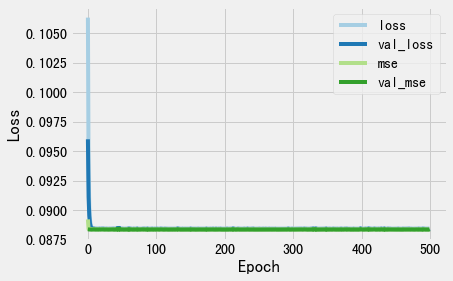



iteration =  6


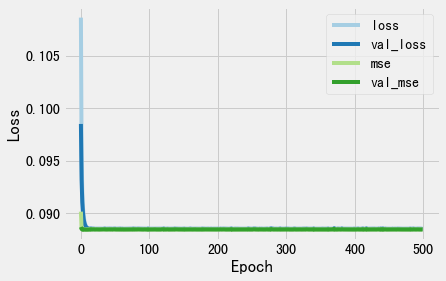



iteration =  7


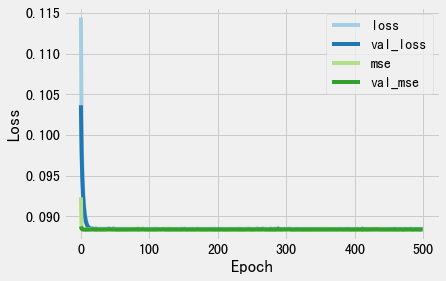



iteration =  8


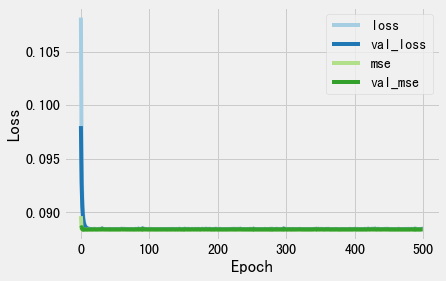



iteration =  9


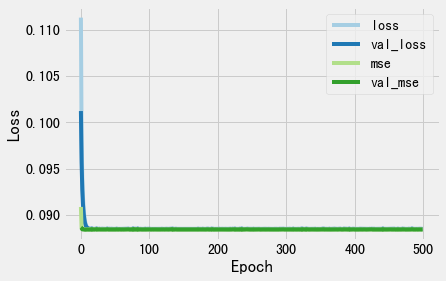



iteration =  10


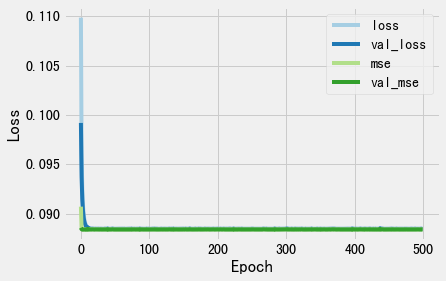



iteration =  11


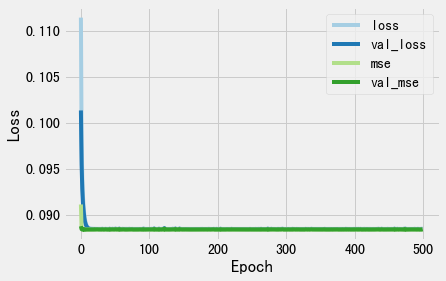



iteration =  12


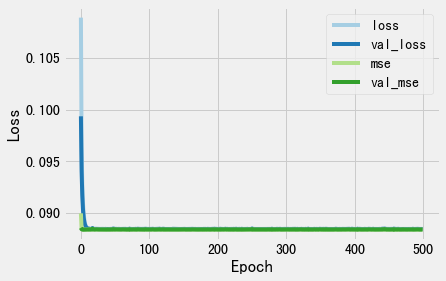



iteration =  13


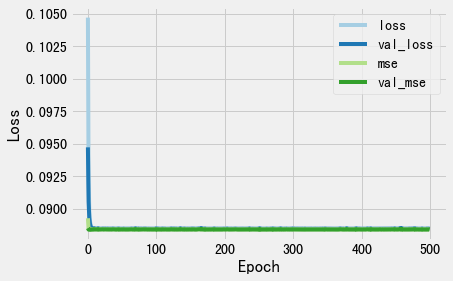



iteration =  14


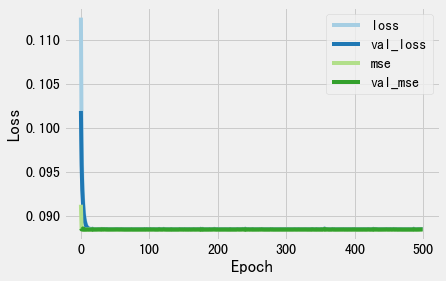



iteration =  15


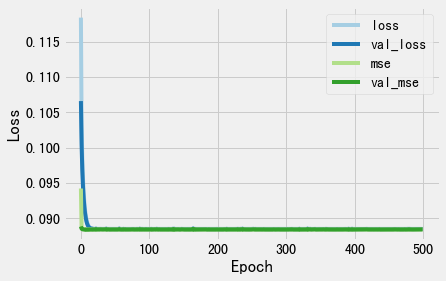



iteration =  16


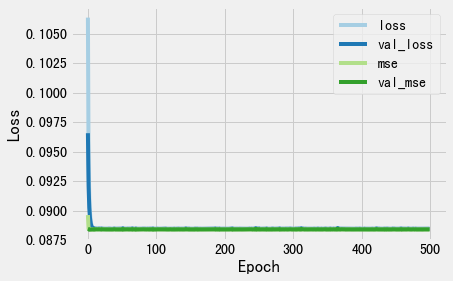



iteration =  17


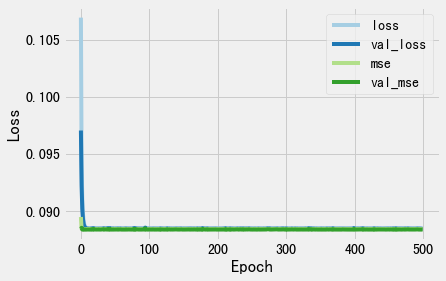



iteration =  18


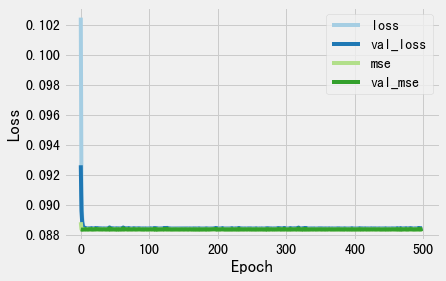



iteration =  19


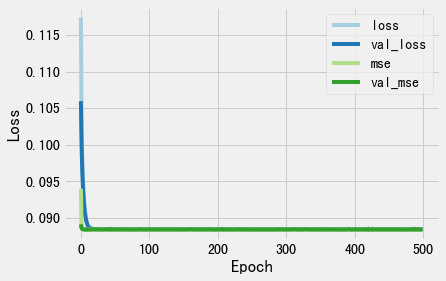



iteration =  20


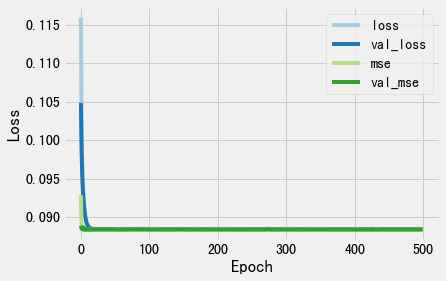

In [33]:
# X LEARNER MODEL
# tau_1 3e-4
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.uplift_model import *

final_model = get_xlearner_model()
final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#lambda y_true,y_pred: y_pred
print('trainable_weights')
for x in final_model.trainable_weights:
    print(x.name)
print('non_trainable_weights')
for x in final_model.non_trainable_weights:
    print(x.name)
final_model.summary()


for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_slearner_model()
    final_model.load_weights('../model_file/uplift/marketing/final_model/slearner/slearner_marketing_model_{}.h5'.format(i+1))
    T0 = np.zeros(shape=T.shape)
    T1 = np.ones(shape=T.shape)
    p0 = final_model.predict([X,  T0])
    p1 = final_model.predict([X,  T1])
    
    X_0 = X[(T.flatten() < 0.5), :]
    X_1 = X[(T.flatten() >= 0.5), :]

    X_0_p1_pre = p1[(T < 0.5)]
    X_1_p0_pre = p0[(T >= 0.5)]

    Yr_0 = Yr[(T < 0.5)]
    Yr_1 = Yr[(T >= 0.5)]

    tau_0_label = X_0_p1_pre - Yr_0
    tau_1_label = Yr_1 - X_1_p0_pre
    
    
#     final_model = get_xlearner_model_tau0()
#     final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

#     mcp_save = ModelCheckpoint('../model_file/uplift/marketing/final_model/xlearner/xlearner_marketing_model_tau_0_{}_3e-4.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
#     history = final_model.fit(X_0, tau_0_label, validation_split=0.2, epochs=500, batch_size=4096, shuffle=True, verbose=0, callbacks=[mcp_save])

#     plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    
    final_model = get_xlearner_model()
    final_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    mcp_save = ModelCheckpoint('../model_file/uplift/marketing/final_model/xlearner/xlearner_marketing_model_tau_1_{}_3e-4.h5'.format(i+1), save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit(X_1, tau_1_label, validation_split=0.2, epochs=500, batch_size=4096, shuffle=True, verbose=0, callbacks=[mcp_save])

    plot_loss(history, "loss", "val_loss", "mse", "val_mse")
    
    print("\n")
    


In [ ]:
# GRF
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
from evaluation.UpliftMetric import *
import pickle


X_grf = X
T_grf = T.flatten()
Yr_grf = Yr.flatten()


for i in range(10):
    
    print("iteration = ", i + 1)
    
    depth = 24
    min_samples_leaf = 300
    n_estimators = 256

    grf_random_state = 20220714 + i * 11
    
    est_it = CausalForestDML(model_y=RandomForestRegressor(n_estimators=160, max_samples = 0.7, random_state=grf_random_state, max_depth=12, min_samples_leaf=500, n_jobs=32),
                          model_t=RandomForestClassifier(n_estimators=160, max_samples = 0.7, random_state=grf_random_state, max_depth=12, min_samples_leaf=500, n_jobs=32),
                          discrete_treatment=True,
                          cv=3,
                          n_estimators=n_estimators,
                          n_jobs=32,
                          max_depth=depth,
                          min_samples_leaf = min_samples_leaf,
                          random_state=grf_random_state)

    est_it.fit(Yr_grf, T_grf, X=X_grf, cache_values=True)
    
    model_file = "../model_file/uplift/marketing/final_model/grf/CausalForestDML_{}.model".format(i + 1)
    
    fw = open(model_file, "wb")

    pickle.dump(est_it, fw)

    fw.close()
    
    print("\n")
    

iteration =  1


iteration =  2


iteration =  3


iteration =  4


iteration =  5


iteration =  6


iteration =  7
